# Preprocessing Keyboard Data

Three types of data are recorded.

1. Old data: Data for Basem and Brian. Using first iteration of keyboard_recorder.
2. research: Originally from the KeyStroke dataset used in the paper. Only the non-Zoom audio
3. New Data: New data recorded after the new keyboard_recorder was made.

Steps for pulling together data

1. Load the data folders
2. Preprocess the files by extracting keystrokes (personal method vs Keystroke method)
3. Encode and format data together across all folders.


End result:
* One pickle file of tabular data
* One folder of data preprocessed for multi-modal modal



In [496]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import yaml
import librosa
import librosa.display
import soundfile as sf
import shutil
import torch
from pynput import keyboard

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## Old Data before rework (User1, User2)

In [497]:
# Define the path to the data folder
data_folder = '../data/old_data/'
output_dir='../preprocessed_data/'
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)  # Delete the folder and its contents
os.makedirs(output_dir)

# Initialize an empty list to store the data
key_data_list = []
sentence_data_list = []

# Loop through all user folders in the data folder
for user_folder in os.listdir(data_folder):
    if 'Keystroke' in user_folder:
        continue
    user_folder_path = os.path.join(data_folder, user_folder)
    if os.path.isdir(user_folder_path):  # Check if it's a directory
        key_folder_path = os.path.join(user_folder_path, 'data', 'key_data')
        sentence_folder_path = os.path.join(user_folder_path, 'data', 'sentence_data')

        # Key data, then sentence data
        # for internal_folder in [key_folder_path, sentence_folder_path]:
        for file_name in os.listdir(key_folder_path):
            # key_folder_path = os.path.join(data_folder, user_folder)
            # Check if the file is a YAML file
            if file_name.endswith('.yaml'):
                # Extract key_pressed value from the filename
                key_pressed = file_name.split('_')[2]
                
                # Construct the full path to the YAML file
                yaml_file_path = os.path.join(key_folder_path, file_name)
                
                # Read the YAML file and filter out the 'key_pressed' field and subsequent lines until 'keyboard_name'
                with open(yaml_file_path, 'r') as file:
                    lines = file.readlines()
                
                filtered_lines = []
                skip = False
                for line in lines:
                    if line.strip().startswith('key_pressed:'):
                        skip = True
                    if skip and line.strip().startswith('keyboard_name:'):
                        skip = False
                    if not skip:
                        filtered_lines.append(line)
                
                # Load the filtered lines into a dictionary
                yaml_data = yaml.safe_load(''.join(filtered_lines))
                
                # Add the user, audio file name, and key_pressed information
                yaml_data['user'] = user_folder
                # yaml_data['audio_file'] = file_name.replace('.yaml', f'_{user_folder}.wav')
                # original_file = file_name.replace('.yaml', '.wav')
                yaml_data['audio_file'] = file_name.replace('.yaml', '.wav') # Assuming audio files are in .wav format
                yaml_data['key_pressed'] = key_pressed

                # Copy the audio file to the output directory
                original_audio_file = yaml_data['audio_file']
                new_audio_file_name = original_audio_file.replace('.wav', f'_{user_folder}.wav')
                source_audio_file_path = os.path.join(key_folder_path, original_audio_file)
                destination_audio_file_path = os.path.join(output_dir, new_audio_file_name)
                shutil.copy2(source_audio_file_path, destination_audio_file_path)
                yaml_data['audio_file'] = new_audio_file_name
                key_data_list.append(yaml_data)

# Convert the list of dictionaries to a DataFrame
key_df = pd.DataFrame(key_data_list)
sentence_df = pd.DataFrame(sentence_data_list)

# Display the DataFrame
key_df.head()

,default_high_input_latency,default_high_output_latency,default_low_input_latency,default_low_output_latency,default_samplerate,hostapi,index,keyboard_name,keyboard_size,keyboard_type,max_input_channels,max_output_channels,name,switch_color,timestamp,user,audio_file,key_pressed
0,0.18,0.18,0.09,0.09,44100.0,0,1,DropCTRLV1,80%_Tenkeyless,mechanical,2,0,Mic/Inst (Samson G-Track Pro),Halo True,1720383597,Basem,key_press_z_1720383597_Basem.wav,z
1,0.18,0.18,0.09,0.09,44100.0,0,1,DropCTRLV1,80%_Tenkeyless,mechanical,2,0,Mic/Inst (Samson G-Track Pro),Halo True,1720383403,Basem,key_press_k_1720383403_Basem.wav,k
2,0.18,0.18,0.09,0.09,44100.0,0,1,DropCTRLV1,80%_Tenkeyless,mechanical,2,0,Mic/Inst (Samson G-Track Pro),Halo True,1720380835,Basem,key_press_4_1720380835_Basem.wav,4
3,0.18,0.18,0.09,0.09,44100.0,0,1,DropCTRLV1,80%_Tenkeyless,mechanical,2,0,Mic/Inst (Samson G-Track Pro),Halo True,1720383189,Basem,key_press_f_1720383189_Basem.wav,f
4,0.18,0.18,0.09,0.09,44100.0,0,1,DropCTRLV1,80%_Tenkeyless,mechanical,2,0,Mic/Inst (Samson G-Track Pro),Halo True,1720383147,Basem,key_press_d_1720383147_Basem.wav,d


### New Data (User 4)

Find the peak for each audio file, then seperate them out.

In [498]:
def calculate_energy(y, sr):
    stft_result = np.abs(librosa.stft(y))
    energy = np.sum(stft_result**2, axis=0)
    energy = energy / np.max(energy)
    return energy

def sliding_window_average(energy, window_size):
    averaged_energy = np.convolve(energy, np.ones(window_size)/window_size, mode='same')
    return averaged_energy

def get_yaml_file(folder_path):
    for file in os.listdir(folder_path):
        if (file.endswith(".yaml") or file.endswith(".yml")):
            yaml_file_path = os.path.join(folder_path, file)
            # Get all yaml data first
            # Read the YAML file and filter out the 'key_pressed' field and subsequent lines until 'keyboard_name'
            with open(yaml_file_path, 'r') as file:
                lines = file.readlines()
            
            # Load the filtered lines into a dictionary
            yaml_data = yaml.safe_load(''.join(lines))
            
            # Add the user, audio file name, and key_pressed information
            user_keyboard_name = yaml_data['keyboard_name']
            user_keyboard_size = yaml_data['keyboard_size']
            keyboard_type = yaml_data['keyboard_type']
            switch_color = yaml_data['switch_color']
            return user_keyboard_name, user_keyboard_size, keyboard_type, switch_color
    return None

def extract_keystrokes(data_folder, low_threshold, high_threshold, output_dir,
                       window_size=50, target_duration=1.0, give_plot=False, debug=False):
    
    for user_folder in os.listdir(data_folder):
        if 'Keystroke' in user_folder:
            continue
        user_folder_path = os.path.join(data_folder, user_folder)
        audio_data = []
        if os.path.isdir(user_folder_path):  # Check if it's a directory
            key_folder_path = os.path.join(user_folder_path, 'key_data')
            user_keyboard_name, user_keyboard_size, keyboard_type, switch_color = get_yaml_file(key_folder_path)
            if not key_folder_path:
                raise('Yaml file for data not found')

            for file_name in os.listdir(key_folder_path):
                if file_name.endswith('.yaml'):
                    continue
                        
                elif file_name.endswith('.wav'):
                    # Wav file
                    key_pressed = file_name.split('_')[2].lower()

                    wav_file_path = os.path.join(key_folder_path, file_name)

                    y, sr = librosa.load(wav_file_path, sr=None)
                    energy = calculate_energy(y, sr)
                    averaged_energy = sliding_window_average(energy, window_size)
                    
                    keystroke_indices = np.where(averaged_energy > low_threshold)[0]
                    
                    keystroke_events = []
                    if len(keystroke_indices) > 0:
                        start_idx = keystroke_indices[0]
                        for i in range(1, len(keystroke_indices)):
                            if keystroke_indices[i] - keystroke_indices[i-1] > 1:
                                end_idx = keystroke_indices[i-1]
                                keystroke_events.append((start_idx, end_idx))
                                start_idx = keystroke_indices[i]
                        keystroke_events.append((start_idx, keystroke_indices[-1]))
                    
                    filtered_keystroke_events = []
                    for start_frame, end_frame in keystroke_events:
                        if np.max(averaged_energy[start_frame:end_frame]) > high_threshold:
                            length = end_frame - start_frame
                            extension = int(0.1 * length)
                            start_frame = max(0, start_frame - extension)
                            end_frame = min(len(averaged_energy), end_frame + extension)
                            filtered_keystroke_events.append((start_frame, end_frame))
                    
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    
                    for i, (start_frame, end_frame) in enumerate(filtered_keystroke_events[1:]):
                        start_sample = librosa.frames_to_samples(start_frame)
                        end_sample = librosa.frames_to_samples(end_frame + 1)
                        
                        keystroke_audio = y[start_sample:end_sample]
                        
                        # Calculate required padding
                        target_samples = int(target_duration * sr)
                        current_samples = len(keystroke_audio)
                        padding_needed = target_samples - current_samples
                        if padding_needed > 0:
                            pad_before = padding_needed // 2
                            pad_after = padding_needed - pad_before
                            keystroke_audio = np.pad(keystroke_audio, (pad_before, pad_after), 'constant')
                        
                        output_path = os.path.join(output_dir, f'key_press_{key_pressed}_{i}_{user_folder}.wav')
                        sf.write(output_path, keystroke_audio, sr)
                        if debug:
                            print(f'Saved keystroke {i} to {output_path}')
                        
                        # Write the filename and additional data to a dataframe.
                        audio_data.append([user_keyboard_name,
                                           user_keyboard_size, 
                                           keyboard_type,
                                           switch_color,
                                           f'key_press_{key_pressed}_{i}_{user_folder}.wav',
                                           key_pressed])

                    if give_plot:
                        # Plot for visualization
                        time = np.linspace(0, len(y) / sr, len(y))
                        frames_time = np.linspace(0, len(energy) * window_size / sr, len(energy))
                        
                        plt.figure(figsize=(15, 7))
                        # plt.plot(time, y, label='Audio Signal')
                        plt.plot(frames_time, averaged_energy, label='Averaged Energy', color='orange')
                        plt.axhline(y=low_threshold, color='black', linestyle=':', label='Low Threshold')
                        plt.axhline(y=high_threshold, color='green', linestyle=':', label='High Threshold')
                        for start_frame, end_frame in filtered_keystroke_events[1:]:
                            plt.axvline(x=start_frame * window_size / sr, color='red', linestyle='-', linewidth=0.2)
                            plt.axvline(x=end_frame * window_size / sr, color='magenta', linestyle='-', linewidth=0.2)
                        plt.xlabel('Time (s)')
                        plt.ylabel('Amplitude / Averaged Energy')
                        plt.legend()
                        plt.title('Keystroke Detection Visualization')
                        plt.show()
    key_df = pd.DataFrame(data=audio_data, columns=['keyboard_name', 'keyboard_size', 'keyboard_type',
                                                    'switch_color', 'audio_file', 'key_pressed'])
    return key_df

# Extract keystrokes with the chosen threshold
audio_path='../data/new_data/'
low_threshold=0.005  # Thresholds must be adjusted
high_threshold=0.01  # Thresholds must be adjusted
output_dir='../preprocessed_data/'
window_size=35
give_plot=False

new_key_df = extract_keystrokes(data_folder=audio_path,
                   low_threshold=low_threshold,
                   high_threshold=high_threshold,
                   output_dir=output_dir,
                   window_size=window_size,
                   give_plot=False)
new_key_df.head()

,keyboard_name,keyboard_size,keyboard_type,switch_color,audio_file,key_pressed
0,Dropctrlv1,80%_Tenkeyless,mechanical,Halo True,key_press_`_0_Newman.wav,`
1,Dropctrlv1,80%_Tenkeyless,mechanical,Halo True,key_press_`_1_Newman.wav,`
2,Dropctrlv1,80%_Tenkeyless,mechanical,Halo True,key_press_`_2_Newman.wav,`
3,Dropctrlv1,80%_Tenkeyless,mechanical,Halo True,key_press_`_3_Newman.wav,`
4,Dropctrlv1,80%_Tenkeyless,mechanical,Halo True,key_press_`_4_Newman.wav,`


-------------

### Grab original audio research data. (User 3)

In [499]:
# Extract keystrokes with the chosen threshold
audio_path='../data/research/'
low_threshold=0.005  # Thresholds must be adjusted
high_threshold=0.01  # Thresholds must be adjusted
output_dir='../preprocessed_data/'
window_size=35
give_plot=False

research_df = extract_keystrokes(data_folder=audio_path,
                   low_threshold=low_threshold,
                   high_threshold=high_threshold,
                   output_dir=output_dir,
                   window_size=window_size,
                   give_plot=give_plot)
research_df.head()

,keyboard_name,keyboard_size,keyboard_type,switch_color,audio_file,key_pressed
0,MacbookProM1,65%_Compact(Default for Macbooks),Scissor,None,key_press_5_0_MBPWavs.wav,5
1,MacbookProM1,65%_Compact(Default for Macbooks),Scissor,None,key_press_5_1_MBPWavs.wav,5
2,MacbookProM1,65%_Compact(Default for Macbooks),Scissor,None,key_press_5_2_MBPWavs.wav,5
3,MacbookProM1,65%_Compact(Default for Macbooks),Scissor,None,key_press_5_3_MBPWavs.wav,5
4,MacbookProM1,65%_Compact(Default for Macbooks),Scissor,None,key_press_5_4_MBPWavs.wav,5


### Combine all three dataframes

In [500]:
combined_key_df = pd.concat([key_df, new_key_df, research_df], ignore_index=True)
combined_key_df.head()

,default_high_input_latency,default_high_output_latency,default_low_input_latency,default_low_output_latency,default_samplerate,hostapi,index,keyboard_name,keyboard_size,keyboard_type,max_input_channels,max_output_channels,name,switch_color,timestamp,user,audio_file,key_pressed
0,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,DropCTRLV1,80%_Tenkeyless,mechanical,2.0,0.0,Mic/Inst (Samson G-Track Pro),Halo True,1.720384e+09,Basem,key_press_z_1720383597_Basem.wav,z
1,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,DropCTRLV1,80%_Tenkeyless,mechanical,2.0,0.0,Mic/Inst (Samson G-Track Pro),Halo True,1.720383e+09,Basem,key_press_k_1720383403_Basem.wav,k
2,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,DropCTRLV1,80%_Tenkeyless,mechanical,2.0,0.0,Mic/Inst (Samson G-Track Pro),Halo True,1.720381e+09,Basem,key_press_4_1720380835_Basem.wav,4
3,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,DropCTRLV1,80%_Tenkeyless,mechanical,2.0,0.0,Mic/Inst (Samson G-Track Pro),Halo True,1.720383e+09,Basem,key_press_f_1720383189_Basem.wav,f
4,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,DropCTRLV1,80%_Tenkeyless,mechanical,2.0,0.0,Mic/Inst (Samson G-Track Pro),Halo True,1.720383e+09,Basem,key_press_d_1720383147_Basem.wav,d


---------
---------
---------
## Begin processing data

## Add Keyboard Material Column

In [501]:
print(np.unique([name.lower().replace(" ", "") for name in combined_key_df['keyboard_name'].values]))

['dropctrlv1' 'keychronq3' 'macbookprom1']


In [502]:
material_mapper = {'dropctrlv1': 'aluminum',
                   'keychronq3': 'aluminum',
                   'macbookprom1': 'aluminum'}
combined_key_df['keyboard_name'] = combined_key_df['keyboard_name'].apply(lambda x: x.lower().replace(" ", ""))
combined_key_df['keyboard_material'] = combined_key_df['keyboard_name'].map(material_mapper)
# combined_key_df.drop('keyboard_name', axis=1, inplace=True)
combined_key_df.head()

,default_high_input_latency,default_high_output_latency,default_low_input_latency,default_low_output_latency,default_samplerate,hostapi,index,keyboard_name,keyboard_size,keyboard_type,max_input_channels,max_output_channels,name,switch_color,timestamp,user,audio_file,key_pressed,keyboard_material
0,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,dropctrlv1,80%_Tenkeyless,mechanical,2.0,0.0,Mic/Inst (Samson G-Track Pro),Halo True,1.720384e+09,Basem,key_press_z_1720383597_Basem.wav,z,aluminum
1,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,dropctrlv1,80%_Tenkeyless,mechanical,2.0,0.0,Mic/Inst (Samson G-Track Pro),Halo True,1.720383e+09,Basem,key_press_k_1720383403_Basem.wav,k,aluminum
2,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,dropctrlv1,80%_Tenkeyless,mechanical,2.0,0.0,Mic/Inst (Samson G-Track Pro),Halo True,1.720381e+09,Basem,key_press_4_1720380835_Basem.wav,4,aluminum
3,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,dropctrlv1,80%_Tenkeyless,mechanical,2.0,0.0,Mic/Inst (Samson G-Track Pro),Halo True,1.720383e+09,Basem,key_press_f_1720383189_Basem.wav,f,aluminum
4,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,dropctrlv1,80%_Tenkeyless,mechanical,2.0,0.0,Mic/Inst (Samson G-Track Pro),Halo True,1.720383e+09,Basem,key_press_d_1720383147_Basem.wav,d,aluminum


## Add Keyboard Microhone Column cleanup

In [503]:
combined_key_df['name'].unique()

microphone_mapper = {'Mic/Inst (Samson G-Track Pro)': 'Samson_GTrack_Pro',
                     'Microphone (3- USB PnP Audio De': 'GenericPnP'}

combined_key_df['microphone'] = combined_key_df['name'].map(microphone_mapper)
combined_key_df.drop('name', axis=1, inplace=True)
combined_key_df.head()

,default_high_input_latency,default_high_output_latency,default_low_input_latency,default_low_output_latency,default_samplerate,hostapi,index,keyboard_name,keyboard_size,keyboard_type,max_input_channels,max_output_channels,switch_color,timestamp,user,audio_file,key_pressed,keyboard_material,microphone
0,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,dropctrlv1,80%_Tenkeyless,mechanical,2.0,0.0,Halo True,1.720384e+09,Basem,key_press_z_1720383597_Basem.wav,z,aluminum,Samson_GTrack_Pro
1,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,dropctrlv1,80%_Tenkeyless,mechanical,2.0,0.0,Halo True,1.720383e+09,Basem,key_press_k_1720383403_Basem.wav,k,aluminum,Samson_GTrack_Pro
2,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,dropctrlv1,80%_Tenkeyless,mechanical,2.0,0.0,Halo True,1.720381e+09,Basem,key_press_4_1720380835_Basem.wav,4,aluminum,Samson_GTrack_Pro
3,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,dropctrlv1,80%_Tenkeyless,mechanical,2.0,0.0,Halo True,1.720383e+09,Basem,key_press_f_1720383189_Basem.wav,f,aluminum,Samson_GTrack_Pro
4,0.18,0.18,0.09,0.09,44100.0,0.0,1.0,dropctrlv1,80%_Tenkeyless,mechanical,2.0,0.0,Halo True,1.720383e+09,Basem,key_press_d_1720383147_Basem.wav,d,aluminum,Samson_GTrack_Pro


## Drop unneeded columns

In [504]:
unnecessary_cols = ['default_high_input_latency',
                    'default_high_output_latency',
                    'default_low_input_latency',
                    'default_low_output_latency',
                    'default_samplerate',
                    'hostapi',
                    'index',
                    'max_input_channels',
                    'max_output_channels',
                    'timestamp',]
combined_key_df.drop(unnecessary_cols, axis=1, inplace=True)

In [505]:
combined_key_df[combined_key_df['key_pressed'] == 'p']

,keyboard_name,keyboard_size,keyboard_type,switch_color,user,audio_file,key_pressed,keyboard_material,microphone
9,dropctrlv1,80%_Tenkeyless,mechanical,Halo True,Basem,key_press_p_1720382799_Basem.wav,p,aluminum,Samson_GTrack_Pro
87,dropctrlv1,80%_Tenkeyless,mechanical,Halo True,Basem,key_press_p_1720382827_Basem.wav,p,aluminum,Samson_GTrack_Pro
108,dropctrlv1,80%_Tenkeyless,mechanical,Halo True,Basem,key_press_p_1720382810_Basem.wav,p,aluminum,Samson_GTrack_Pro
146,dropctrlv1,80%_Tenkeyless,mechanical,Halo True,Basem,key_press_p_1720382820_Basem.wav,p,aluminum,Samson_GTrack_Pro
221,dropctrlv1,80%_Tenkeyless,mechanical,Halo True,Basem,key_press_p_1720382823_Basem.wav,p,aluminum,Samson_GTrack_Pro
245,dropctrlv1,80%_Tenkeyless,mechanical,Halo True,Basem,key_press_p_1720382803_Basem.wav,p,aluminum,Samson_GTrack_Pro
250,dropctrlv1,80%_Tenkeyless,mechanical,Halo True,Basem,key_press_p_1720382796_Basem.wav,p,aluminum,Samson_GTrack_Pro
316,dropctrlv1,80%_Tenkeyless,mechanical,Halo True,Basem,key_press_p_1720382806_Basem.wav,p,aluminum,Samson_GTrack_Pro
380,dropctrlv1,80%_Tenkeyless,mechanical,Halo True,Basem,key_press_p_1720382813_Basem.wav,p,aluminum,Samson_GTrack_Pro
465,dropctrlv1,80%_Tenkeyless,mechanical,Halo True,Basem,key_press_p_1720382817_Basem.wav,p,aluminum,Samson_GTrack_Pro


Switch_colors to switch_type
switch_type(clicky, tactile, linear, NA(membrane))


In [507]:
switches_dict = {
    'Clicky': [
        'Cherry MX Blue', 'Cherry MX Green', 'Cherry MX White',
        'Gateron Blue', 'Gateron Green',
    ],
    'Tactile': [
        'Cherry MX Brown', 'Cherry MX Clear',
        'Gateron Brown', 'Halo True', 'Halo Clear',
    ],
    'Linear': [
        'Cherry MX Red', 'Cherry MX Black', 'Cherry MX Silent Red', 'Cherry MX Speed Silver',
        'Gateron Red', 'Gateron Black', 'Gateron Silent Red', 'Gateron Yellow',
        'Cherry MX Grey', 'Gateron Clear', 'Gateron White',
    ],
    'None': ['None']
}

def map_switch_type(switch):
    for key, values in switches_dict.items():
        if switch in values:
            return key
    print(f"{switch} was not in any category. setting to NA")
    return 'NA'  # If switch doesn't match any category

# Apply the mapping function to the 'switch_type' column
combined_key_df['switch_type'] = combined_key_df['switch_color'].map(lambda x: map_switch_type(x))
combined_key_df.drop(['switch_color'], axis=1, inplace=True)

combined_key_df.head()

,keyboard_name,keyboard_size,keyboard_type,user,audio_file,key_pressed,keyboard_material,microphone,switch_type
0,dropctrlv1,80%_Tenkeyless,mechanical,Basem,key_press_z_1720383597_Basem.wav,z,aluminum,Samson_GTrack_Pro,Tactile
1,dropctrlv1,80%_Tenkeyless,mechanical,Basem,key_press_k_1720383403_Basem.wav,k,aluminum,Samson_GTrack_Pro,Tactile
2,dropctrlv1,80%_Tenkeyless,mechanical,Basem,key_press_4_1720380835_Basem.wav,4,aluminum,Samson_GTrack_Pro,Tactile
3,dropctrlv1,80%_Tenkeyless,mechanical,Basem,key_press_f_1720383189_Basem.wav,f,aluminum,Samson_GTrack_Pro,Tactile
4,dropctrlv1,80%_Tenkeyless,mechanical,Basem,key_press_d_1720383147_Basem.wav,d,aluminum,Samson_GTrack_Pro,Tactile


## Final droppings

In [508]:
combined_key_df.drop(['microphone'], axis=1, inplace=True)
combined_key_df.head()

,keyboard_name,keyboard_size,keyboard_type,user,audio_file,key_pressed,keyboard_material,switch_type
0,dropctrlv1,80%_Tenkeyless,mechanical,Basem,key_press_z_1720383597_Basem.wav,z,aluminum,Tactile
1,dropctrlv1,80%_Tenkeyless,mechanical,Basem,key_press_k_1720383403_Basem.wav,k,aluminum,Tactile
2,dropctrlv1,80%_Tenkeyless,mechanical,Basem,key_press_4_1720380835_Basem.wav,4,aluminum,Tactile
3,dropctrlv1,80%_Tenkeyless,mechanical,Basem,key_press_f_1720383189_Basem.wav,f,aluminum,Tactile
4,dropctrlv1,80%_Tenkeyless,mechanical,Basem,key_press_d_1720383147_Basem.wav,d,aluminum,Tactile


## Replace None switch_type with Scissor

In [509]:
combined_key_df[combined_key_df['switch_type'] == "None"]

,keyboard_name,keyboard_size,keyboard_type,user,audio_file,key_pressed,keyboard_material,switch_type
984,macbookprom1,65%_Compact(Default for Macbooks),Scissor,NaN,key_press_5_0_MBPWavs.wav,5,aluminum,None
985,macbookprom1,65%_Compact(Default for Macbooks),Scissor,NaN,key_press_5_1_MBPWavs.wav,5,aluminum,None
986,macbookprom1,65%_Compact(Default for Macbooks),Scissor,NaN,key_press_5_2_MBPWavs.wav,5,aluminum,None
987,macbookprom1,65%_Compact(Default for Macbooks),Scissor,NaN,key_press_5_3_MBPWavs.wav,5,aluminum,None
988,macbookprom1,65%_Compact(Default for Macbooks),Scissor,NaN,key_press_5_4_MBPWavs.wav,5,aluminum,None
...,...,...,...,...,...,...,...,...
1835,macbookprom1,65%_Compact(Default for Macbooks),Scissor,NaN,key_press_3_19_MBPWavs.wav,3,aluminum,None
1836,macbookprom1,65%_Compact(Default for Macbooks),Scissor,NaN,key_press_3_20_MBPWavs.wav,3,aluminum,None
1837,macbookprom1,65%_Compact(Default for Macbooks),Scissor,NaN,key_press_3_21_MBPWavs.wav,3,aluminum,None
1838,macbookprom1,65%_Compact(Default for Macbooks),Scissor,NaN,key_press_3_22_MBPWavs.wav,3,aluminum,None


In [510]:
combined_key_df['switch_type'] = combined_key_df['switch_type'].replace('None', 'Scissor')
combined_key_df[combined_key_df['switch_type'] == "None"]


,keyboard_name,keyboard_size,keyboard_type,user,audio_file,key_pressed,keyboard_material,switch_type


# Exploring Keyboard Data


**1. Clustering Audio Data**

Step 1: Feature Extraction from Audio

Extract features from the audio files to use for clustering. Mel-frequency cepstral coefficients (MFCCs) are commonly used for this purpose.

In [511]:
# Function to extract MFCC features
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return np.mean(mfccs.T, axis=0)

# Extract features and add them to the dataframe
dataviz_df = combined_key_df.copy(deep=True)
dataviz_df['audio_features'] = dataviz_df['audio_file'].apply(lambda x: extract_features(f'../preprocessed_data/{x}'))

# Convert features to a numpy array
features = np.vstack(dataviz_df['audio_features'].to_numpy())

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [512]:
dataviz_df.head()

,keyboard_name,keyboard_size,keyboard_type,user,audio_file,key_pressed,keyboard_material,switch_type,audio_features
0,dropctrlv1,80%_Tenkeyless,mechanical,Basem,key_press_z_1720383597_Basem.wav,z,aluminum,Tactile,"[-705.6469, 111.393196, 23.200048, 21.263632, ..."
1,dropctrlv1,80%_Tenkeyless,mechanical,Basem,key_press_k_1720383403_Basem.wav,k,aluminum,Tactile,"[-709.61237, 112.24388, 29.309193, 26.189089, ..."
2,dropctrlv1,80%_Tenkeyless,mechanical,Basem,key_press_4_1720380835_Basem.wav,4,aluminum,Tactile,"[-719.65405, 111.73628, 34.78793, 25.591984, 1..."
3,dropctrlv1,80%_Tenkeyless,mechanical,Basem,key_press_f_1720383189_Basem.wav,f,aluminum,Tactile,"[-706.98346, 111.735954, 27.941551, 29.110788,..."
4,dropctrlv1,80%_Tenkeyless,mechanical,Basem,key_press_d_1720383147_Basem.wav,d,aluminum,Tactile,"[-714.7464, 112.05822, 32.889168, 29.012405, 1..."


**Step 2: Clustering**

Use K-Means or another clustering algorithm to cluster the audio data.

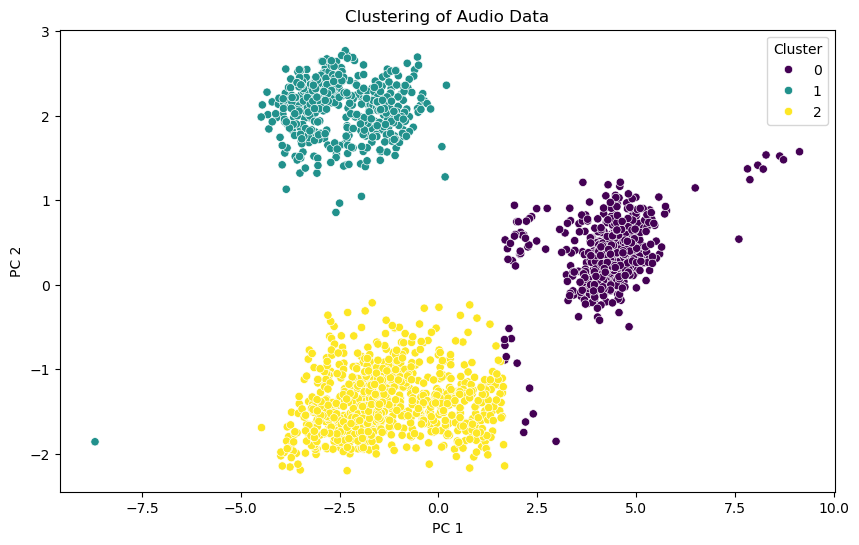

In [513]:
# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)
dataviz_df['PCA_Feature_A'] = features_pca[:, 0]
dataviz_df['PCA_Feature_B'] = features_pca[:, 1]

# KMeans clustering
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(features_pca)

# Add clusters to the dataframe
dataviz_df['cluster'] = clusters

# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x=dataviz_df['PCA_Feature_A'], y=dataviz_df['PCA_Feature_B'], hue=dataviz_df['cluster'], palette='viridis')
plt.title('Clustering of Audio Data')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(title='Cluster')
plt.show()

**Step 3: Filter by Additional Features**

You can add filters for keyboard_material, switch_type, and keyboard_size using seaborn or matplotlib to visualize their relation.

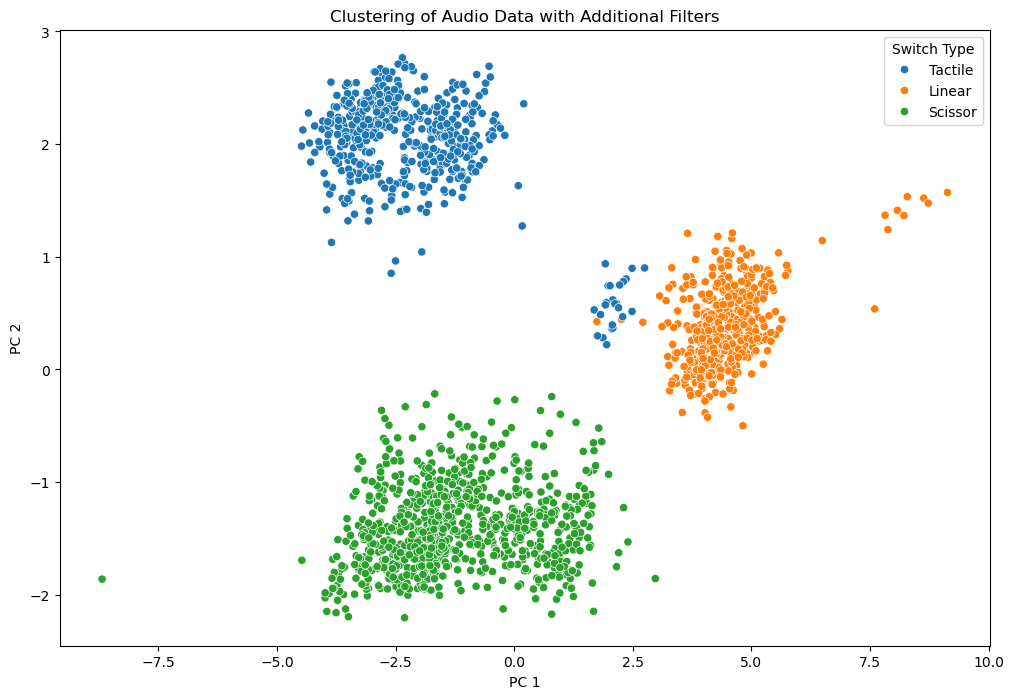

In [514]:
# Filtered Scatter Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=dataviz_df['switch_type']) #, style=dataviz_df['keyboard_material'])
plt.title('Clustering of Audio Data with Additional Filters')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(title='Switch Type')
plt.show()

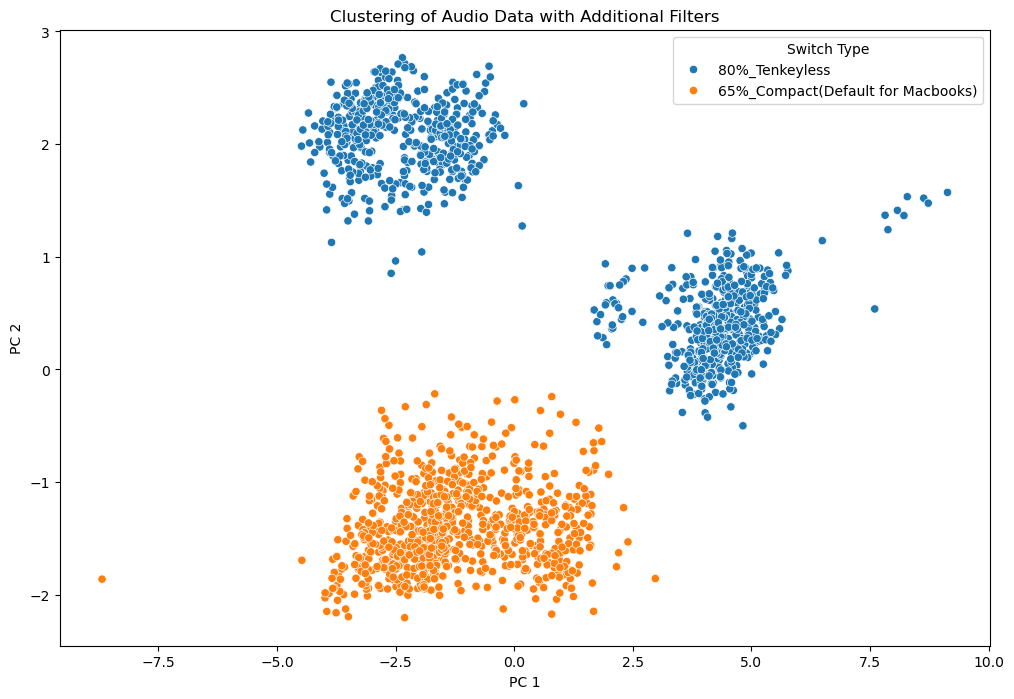

In [518]:
# Filtered Scatter Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=dataviz_df['keyboard_size']) #, style=dataviz_df['keyboard_material'])
plt.title('Clustering of Audio Data with Additional Filters')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(title='Switch Type')
plt.show()

**2. Bar Chart for Key Counts**

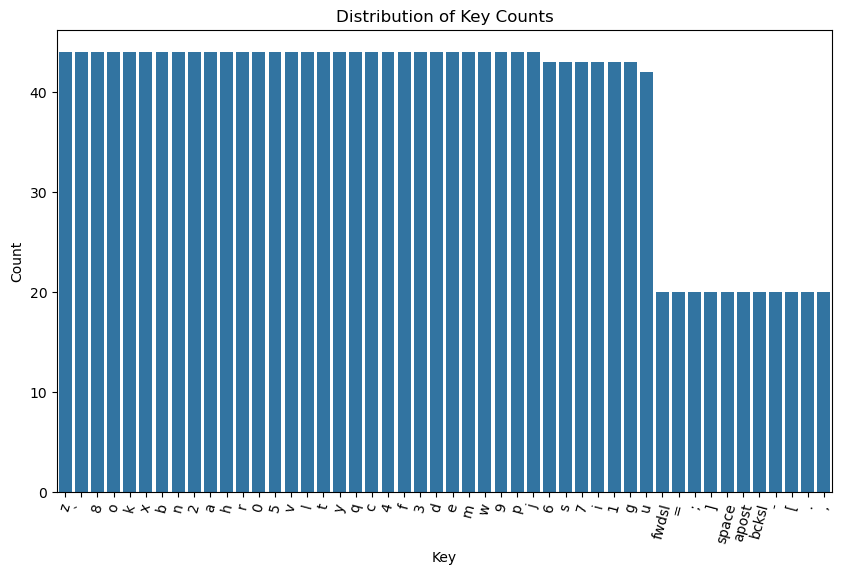

In [520]:
# Count the occurrences of each key
key_counts = dataviz_df['key_pressed'].value_counts()

# Bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=key_counts.index, y=key_counts.values)
plt.title('Distribution of Key Counts')
plt.xlabel('Key')
plt.ylabel('Count')
plt.xticks(rotation=75)
plt.show()

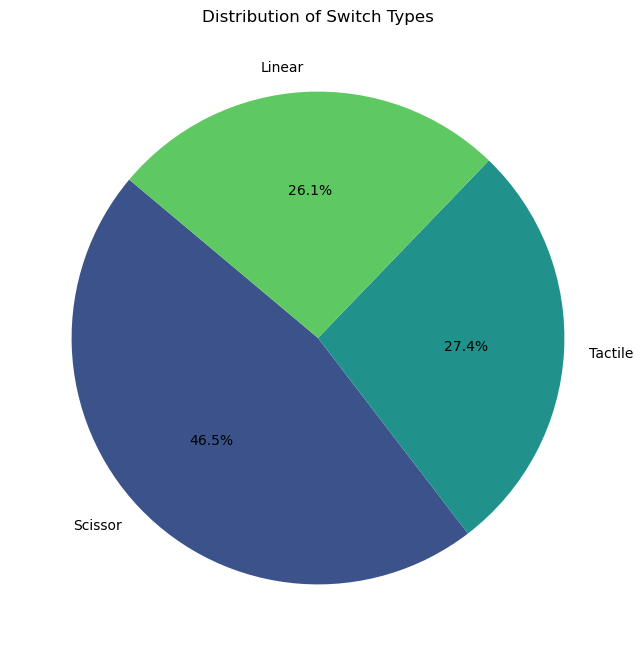

In [521]:
# Pie chart
plt.figure(figsize=(8, 8))
switch_type_counts = dataviz_df['switch_type'].value_counts()
plt.pie(switch_type_counts, labels=switch_type_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(switch_type_counts)))
plt.title('Distribution of Switch Types')
plt.show()

Create first dataviz dataframe

In [ ]:
dataviz_df.head()

This csv saved will create the non-keyboard map plots such as the pie chart, bar chart, and clustering chart.

In [522]:
dataviz_df.drop('audio_features',axis=1, inplace=True)
dataviz_df.to_csv('individual_keys.csv', index=False)

## Generate csv for keyboard map

In [523]:
# Load the original DataFrame
keyboard_map_df = dataviz_df.copy(deep=True)

# Function to calculate the average amplitude of an audio file
def calculate_average_amplitude(file_path):
    try:
        data, _ = sf.read(file_path)
        return np.mean(np.abs(data))
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return np.nan

# Add a new column to the DataFrame with the average amplitude
keyboard_map_df['average_amplitude'] = keyboard_map_df['audio_file'].apply(lambda x: calculate_average_amplitude(f'../preprocessed_data/{x}'))

# Group by 'key_pressed' to calculate the count and average amplitude
keyboard_map_final_df = keyboard_map_df.groupby('key_pressed').agg(
    key_count=('key_pressed', 'size'),
    average_amplitude=('average_amplitude', 'mean')
).reset_index()

keyboard_map_final_df.head()

,key_pressed,key_count,average_amplitude
0,",",20,0.001219
1,-,20,0.001190
2,.,20,0.001120
3,0,44,0.013282
4,1,43,0.006235


In [524]:
# Sort, then create dictionary
keyboard_dict = { 
    0: '`', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '0', 11: '-', 12: '=',
    13: 'q', 14: 'w', 15: 'e', 16: 'r', 17: 't', 18: 'y', 19: 'u', 20: 'i', 21: 'o', 22: 'p', 23: '[', 24: ']', 25:'bcksl',
    26: 'a', 27: 's', 28: 'd', 29: 'f', 30: 'g', 31: 'h', 32: 'j', 33: 'k', 34: 'l', 35: ';', 36: 'apost',
    37: 'z', 38: 'x', 39: 'c', 40: 'v', 41: 'b', 42: 'n', 43: 'm', 44: ',', 45: '.', 46: 'fwdsl', 47: 'space',
}
key_order = {value: key for key, value in keyboard_dict.items()}

# Add a temporary sorting key column to the DataFrame based on the 'key_pressed' column
keyboard_map_final_df['sort_key'] = keyboard_map_final_df['key_pressed'].map(key_order)

# Sort the DataFrame by the temporary sorting key column
keyboard_map_final_df = keyboard_map_final_df.sort_values(by='sort_key')

# Drop the temporary sorting key column, retaining the original column names
keyboard_map_final_df.drop(columns='sort_key', inplace=True)

keyboard_map_final_df.head()

,key_pressed,key_count,average_amplitude
17,`,44,0.001296
4,1,43,0.006235
5,2,44,0.006932
6,3,44,0.007211
7,4,44,0.007931


In [525]:
coordinates = [[11.55, 591.37],
               [131.39, 591.37],
               [244.38, 591.37],
               [360.63, 591.37],
               [476.66, 591.37],
               [589.28, 591.37],
               [700.64, 591.37],
               [813.66, 591.37],
               [925.42, 591.37],
               [1040.89, 591.37],
               [1149.80, 591.37],
               [1262.42, 591.37],
               [1375.89, 591.37],
               
               [190.86, 472.15],
               [300.91, 472.15],
               [416.94, 472.15],
               [525.29, 472.15],
               [640.47, 472.15],
               [754.79, 472.15],
               [867.41, 472.15],
               [980.03, 472.15],
               [1093.50, 472.15],
               [1207.82, 472.15],
               [1319.58, 472.15],
               [1433.91, 472.15],
               [1547.38, 472.15],

               [216.11, 363.03],
               [333.63, 363.03],
               [446.76, 363.03],
               [557.26, 363.03],
               [669.51, 363.03],
               [782.64, 363.03],
               [896.65, 363.03],
               [1013.78, 363.03],
               [1122.91, 363.03],
               [1236.04, 363.03],
               [1347.74, 363.03],

               [272.24, 250.68],
               [388.00, 250.68],
               [499.38, 250.68],
               [614.26, 250.68],
               [725.64, 250.68],
               [839.65, 250.68],
               [953.65, 250.68],
               [1065.91, 250.68],
               [1180.00, 250.68],
               [1293.92, 250.68],

               [786.00, 130.43]
               ]

np.array(coordinates)[:, 0] + 60

array([  71.55,  191.39,  304.38,  420.63,  536.66,  649.28,  760.64,
        873.66,  985.42, 1100.89, 1209.8 , 1322.42, 1435.89,  250.86,
        360.91,  476.94,  585.29,  700.47,  814.79,  927.41, 1040.03,
       1153.5 , 1267.82, 1379.58, 1493.91, 1607.38,  276.11,  393.63,
        506.76,  617.26,  729.51,  842.64,  956.65, 1073.78, 1182.91,
       1296.04, 1407.74,  332.24,  448.  ,  559.38,  674.26,  785.64,
        899.65, 1013.65, 1125.91, 1240.  , 1353.92,  846.  ])

For the Map, add X,Y coordinates for each key

In [526]:
keyboard_map_final_df['X'] = np.array(coordinates)[:, 0] + 40
keyboard_map_final_df['Y'] = np.array(coordinates)[:, 1] - 50
# keyboard_map_final_df.loc[-1, 'X'] += 50

keyboard_map_final_df.head()

,key_pressed,key_count,average_amplitude,X,Y
17,`,44,0.001296,51.55,541.37
4,1,43,0.006235,171.39,541.37
5,2,44,0.006932,284.38,541.37
6,3,44,0.007211,400.63,541.37
7,4,44,0.007931,516.66,541.37


In [527]:
keyboard_map_final_df.to_csv('keyboard_map_final_df_5.csv', index=False)

-----------
---------
--------
